In [532]:
import numpy as np
import pandas as pd
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [533]:
df1 = pd.read_csv('census-income.data.csv')
df2 = pd.read_csv('census-income.test.csv')

In [534]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_countr   32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [535]:
def determine_type_of_feature(df):
    feature_types = []
    n_unique_values_threshold = 15

    for column in df.columns:
        unique_values = df[column].unique()
        example_value = unique_values[0]

        if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_threshold):
            feature_types.append("Discrete")
        else:
            feature_types.append("Continuous")
    
    return feature_types

In [536]:
global FEATURE_TYPES
FEATURE_TYPES = determine_type_of_feature(df1)

In [537]:
def missing_values(df):
    c=0
    for i in df.columns:
        x,count_missing = np.unique(df[i].eq('?'),return_counts=True)
        if len(x)==2:
            print(i,"-",FEATURE_TYPES[c],"-",count_missing[1])
        # elif len(x)==1 and x[0] == False:
        #     print(i,"-",FEATURE_TYPES[c],"- 0",)
        c+=1

In [538]:
def fill_values(df):
    #Since all columns are having the discrete value. We replace it with the missing values with the modes, i.e. the highest appearing value
    mode_workclass = df.workclass.mode()[0]
    mode_occupation = df.occupation.mode()[0]
    mode_native_countr = df.native_countr.mode()[0]

    #Filling the train and test data with the modes of missing values as they are discrete
    df.workclass = df.workclass.replace('?', mode_workclass)
    df.occupation = df.occupation.replace('?', mode_occupation)
    df.native_countr = df.native_countr.replace('?', mode_native_countr)
    missing_values(df)#No missing values
    return df

In [539]:
df2['label'] = df2['label'].str.replace('.', '')
missing_values(df1)
missing_values(df2)
fill_values(df1)
fill_values(df2)

workclass - Discrete - 1836
occupation - Discrete - 1843
native_countr - Discrete - 583
workclass - Discrete - 963
occupation - Discrete - 966
native_countr - Discrete - 274


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_countr,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,Private,321403,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [540]:
def train_test_split(df,test_size):
    #checks whether the test_size is a proportion of the total number of samples
    if isinstance(test_size,float): 
        test_size = round(test_size*len(df))

    #store random samples in the test and training data
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k = test_size)

    #random data points from sample sent to test and training data
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df , test_df

In [541]:
df_combined = pd.concat([df1,df2],ignore_index=True)

In [542]:
workclass_dict = {
    'Federal-gov': 1,
    'Local-gov': 2,
    'Never-worked': 3,
    'Private': 4,
    'Self-emp-inc': 5,
    'Self-emp-not-inc': 6,
    'State-gov': 7,
    'Without-pay': 8
}

education_dict = {
    '10th': 1,
    '11th': 2,
    '12th': 3,
    '1st-4th': 4,
    '5th-6th': 5,
    '7th-8th': 6,
    '9th': 7,
    'Assoc-acdm': 8,
    'Assoc-voc': 9,
    'Bachelors': 10,
    'Doctorate': 11,
    'HS-grad': 12,
    'Masters': 13,
    'Preschool': 14,
    'Prof-school': 15,
    'Some-college': 16
}

marital_status_dict = {
    'Divorced': 1,
    'Married-AF-spouse': 2,
    'Married-civ-spouse': 3,
    'Married-spouse-absent': 4,
    'Never-married': 5,
    'Separated': 6,
    'Widowed': 7
}

occupation_dict = {
    'Adm-clerical': 1,
    'Armed-Forces': 2,
    'Craft-repair': 3,
    'Exec-managerial': 4,
    'Farming-fishing': 5,
    'Handlers-cleaners': 6,
    'Machine-op-inspct': 7,
    'Other-service': 8,
    'Priv-house-serv': 9,
    'Prof-specialty': 10,
    'Protective-serv': 11,
    'Sales': 12,
    'Tech-support': 13,
    'Transport-moving': 14
}

relationship_dict = {
    'Husband': 1,
    'Not-in-family': 2,
    'Other-relative': 3,
    'Own-child': 4,
    'Unmarried': 5,
    'Wife': 6
}

race_dict = {
    'Amer-Indian-Eskimo': 1,
    'Asian-Pac-Islander': 2,
    'Black': 3,
    'Other': 4,
    'White': 5
}

sex_dict = {
    'Female': 1,
    'Male': 2
}

native_countr_dict = {
    'Cambodia': 1,
    'Canada': 2,
    'China': 3,
    'Columbia': 4,
    'Cuba': 5,
    'Dominican-Republic': 6,
    'Ecuador': 7,
    'El-Salvador': 8,
    'England': 9,
    'France': 10,
    'Germany': 11,
    'Greece': 12,
    'Guatemala': 13,
    'Haiti': 14,
    'Holand-Netherlands': 15,
    'Honduras': 16,
    'Hong': 17,
    'Hungary': 18,
    'India': 19,
    'Iran': 20,
    'Ireland': 21,
    'Italy': 22,
    'Jamaica': 23,
    'Japan': 24,
    'Laos': 25,
    'Mexico': 26,
    'Nicaragua': 27,
    'Outlying-US(Guam-USVI-etc)': 28,
    'Peru': 29,
    'Philippines': 30,
    'Poland': 31,
    'Portugal': 32,
    'Puerto-Rico': 33,
    'Scotland': 34,
    'South': 35,
    'Taiwan': 36,
    'Thailand': 37,
    'Trinadad&Tobago': 38,
    'United-States': 39,
    'Vietnam': 40,
    'Yugoslavia': 41
}

label_dict = {
    '<=50K': 0,
    '>50K': 1
}

In [543]:
df_combined.workclass = df_combined.workclass.map(workclass_dict)

df_combined.education = df_combined.education.map(education_dict)

df_combined.marital_status = df_combined.marital_status.map(marital_status_dict)

df_combined.occupation = df_combined.occupation.map(occupation_dict)

df_combined.relationship = df_combined.relationship.map(relationship_dict)

df_combined.race = df_combined.race.map(race_dict)

df_combined.sex = df_combined.sex.map(sex_dict)

df_combined.native_countr = df_combined.native_countr.map(native_countr_dict)

df_combined.label = df_combined.label.map(label_dict)

In [544]:
df_combined.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_countr,label
0,39,7,77516,10,13,5,1,2,5,2,2174,0,40,39,0
1,50,6,83311,10,13,3,4,1,5,2,0,0,13,39,0
2,38,4,215646,12,9,1,6,2,5,2,0,0,40,39,0
3,53,4,234721,2,7,3,6,1,3,2,0,0,40,39,0
4,28,4,338409,10,13,3,10,6,3,1,0,0,40,5,0


In [545]:
df_train , df_test = train_test_split(df_combined , 0.33)
random.seed(0)

df_test.head()

In [546]:
y_test = df_test.label.values

df_test = df_test.drop('label',axis = 1)

x_test = df_test.values


In [547]:
y_train = df_train.label.values

df_train = df_train.drop('label',axis =1)

x_train = df_train.values



In [548]:
x_train = x_train.T
x_test = x_test.T

In [549]:
y_test.shape[0]

16118

In [550]:
def normalize_data(data):
    max_row = np.amax(data,axis=1)
    min_row = np.amin(data,axis=1)
    diff = max_row-min_row
    diff = diff.reshape(diff.shape[0],1)
    max_row = max_row.reshape(max_row.shape[0],1)
    min_row = min_row.reshape(min_row.shape[0],1)
    diff = diff.reshape(diff.shape[0],1)
    data = np.divide((data-min_row),diff)

    return(data)

In [551]:
x_test = normalize_data(x_test)
x_train = normalize_data(x_train)

In [552]:
x_test

array([[0.08219178, 0.36986301, 0.02739726, ..., 0.32876712, 0.        ,
        0.02739726],
       [0.42857143, 0.42857143, 0.42857143, ..., 0.42857143, 0.42857143,
        0.42857143],
       [0.01331003, 0.12494726, 0.06872333, ..., 0.19527763, 0.08049878,
        0.16104904],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29591837, 0.42857143, 0.39795918, ..., 0.39795918, 0.14285714,
        0.13265306],
       [0.95      , 0.95      , 0.975     , ..., 0.95      , 0.95      ,
        0.95      ]])

In [553]:
x_train

array([[0.30136986, 0.28767123, 0.49315068, ..., 0.28767123, 0.36986301,
        0.24657534],
       [0.85714286, 0.42857143, 0.42857143, ..., 0.42857143, 0.42857143,
        0.57142857],
       [0.04520043, 0.14091467, 0.15413228, ..., 0.25132384, 0.04961785,
        0.11770294],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.39795918, 0.39795918, 0.39795918, ..., 0.5       , 0.39795918,
        0.60204082],
       [0.95      , 0.95      , 0.95      , ..., 0.95      , 0.95      ,
        0.95      ]])

In [554]:
m_train = x_train.shape[1]
m_test = x_test.shape[1]

print("Number of training examples: m_train =", m_train)
print("Number of testing examples: m_test =", m_test)

print("train_set_x shape:", x_train.shape)
print("train_set_y shape:", y_train.shape)
print("test_set_x shape:", x_test.shape)
print("test_set_y shape:", y_test.shape)


Number of training examples: m_train = 32724
Number of testing examples: m_test = 16118
train_set_x shape: (14, 32724)
train_set_y shape: (32724,)
test_set_x shape: (14, 16118)
test_set_y shape: (16118,)


In [555]:
X_train = x_train.T
y_train = y_train.reshape(-1, 1)
X_test = x_test.T
y_test = y_test.reshape(-1, 1)

In [556]:
# class NaiveBayes:
    
#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         self._classes = np.unique(y)
#         n_classes = len(self._classes)

#         # Calculate mean, var, and prior for each hypothesis
#         self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
#         self._var = np.zeros((n_classes, n_features), dtype=np.float64)
#         self._priors = np.zeros(n_classes, dtype=np.float64)

#         for idx, c in enumerate(self._classes):
#             X_c = X[y==c]
#             self._mean[idx, :] = X_c.mean(axis=0)
#             self._var[idx, :] = X_c.var(axis=0)
#             self._priors[idx] = X_c.shape[0] / float(n_samples)

#     def predict(self, X):
#         y_pred = [self._predict(x) for x in X]
#         return np.array(y_pred)
    
#     def _predict(self, x):
#         posteriors = []

#         # Calculate posterior probability for each class
#         for idx, c in enumerate(self._classes):
#             prior = np.log(self._priors[idx])
#             epsilon = 1e-8
#             posterior = np.sum(np.log(self._pdf(idx, x)+ epsilon))
#             posterior = posterior + prior
#             posteriors.append(posterior)

#         # Return class with max posterior
#         return self._classes[np.argmax(posteriors)]
    
#     def _pdf(self, class_idx, x):
#         mean = self._mean[class_idx]
#         var = self._var[class_idx]
#         numerator = np.exp(-((x - mean)**2) / (2 * var))
#         denominator = np.sqrt(2 * np.pi * var)
#         return numerator / denominator

In [557]:
nb = GaussianNB()

In [558]:
nb.fit(X_train, y_train.ravel())

GaussianNB()

In [559]:
y_pred = nb.predict(X_test)

In [560]:
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes classification accuracy:", accuracy)

Naive Bayes classification accuracy: 0.8020846258841047


In [561]:
cm = confusion_matrix(y_test, y_pred)



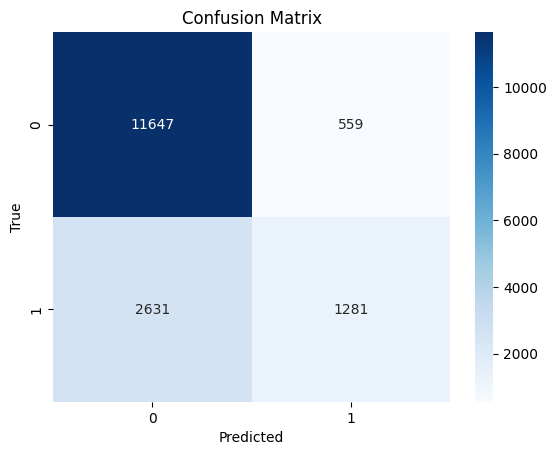

In [562]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [563]:
y_prob = nb.predict(X_test)

# Compute false positive rate (FPR), true positive rate (TPR), and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

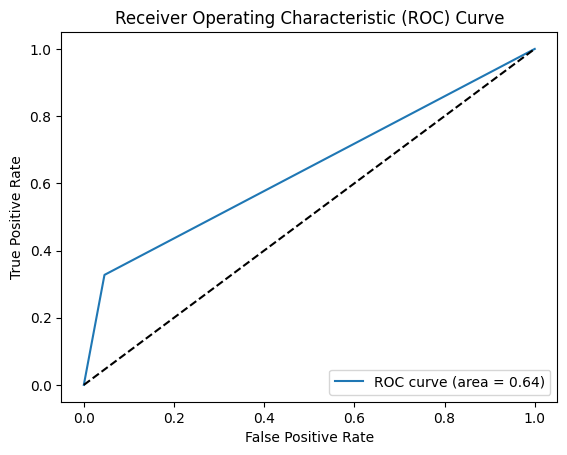

In [564]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [565]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

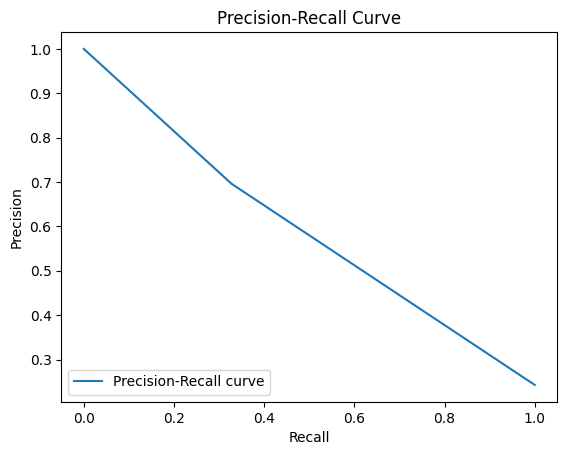

In [566]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()